# Cora Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx, to_dense_adj

In [2]:
dataset = Planetoid(root="data", name="Cora")

print(f"num documents : {dataset.num_features}")
print(f"num classes : {dataset.num_classes}")

data = dataset[0]

print(f"Size information matrix : {data.x.shape}")
print(f"Size target vector : {data.y.shape}")
print(f"Size trainset : {data.train_mask.sum()}")
print(f"Size testset : {data.test_mask.sum()}")

print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')


num documents : 1433
num classes : 7
Size information matrix : torch.Size([2708, 1433])
Size target vector : torch.Size([2708])
Size trainset : 140
Size testset : 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


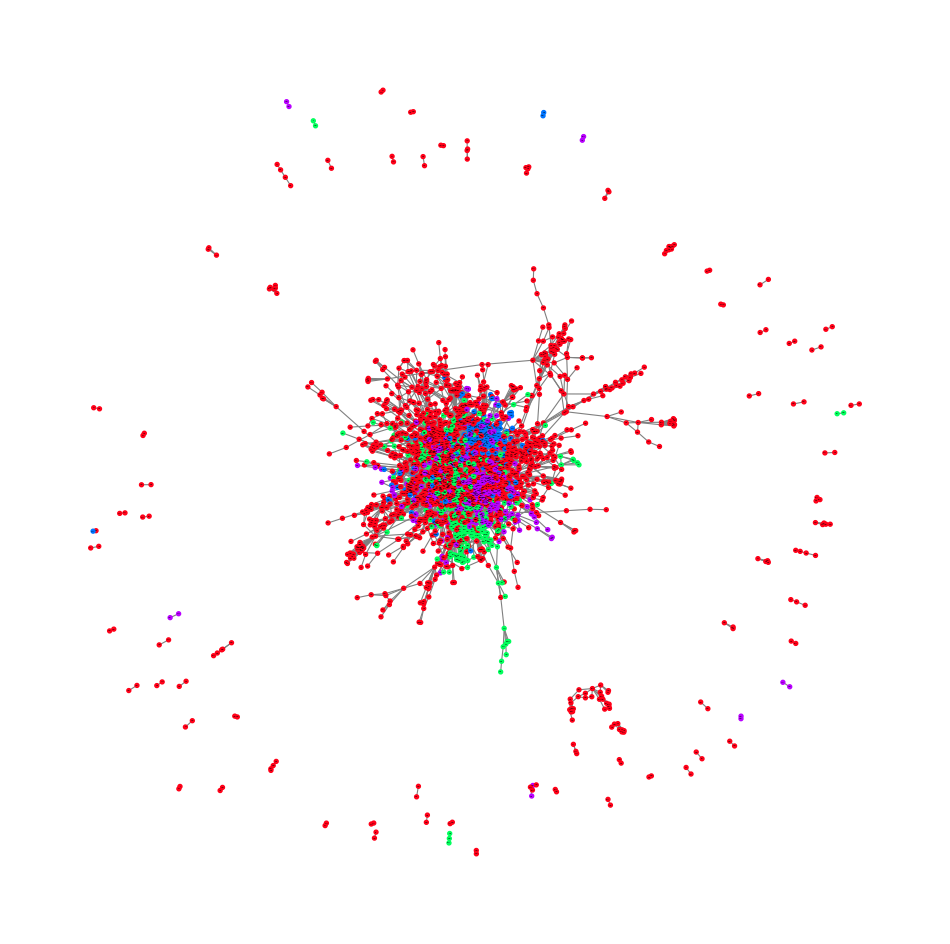

In [3]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=8,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=0
                )
plt.show()

# Graph Convolution Network for Classification

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from utils import accuracy

from model import GCN

In [5]:
X = data.x
y = data.y
A = to_dense_adj(data.edge_index).squeeze(0)

train_index = dataset.train_mask==True
test_index = dataset.test_mask==True

In [6]:
EPOCHS = 100
LEARNING_RATE = 1e-2

model = GCN(in_channels=dataset.num_features, hidden_dim=16, out_channels=dataset.num_classes, adj = A)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)

In [7]:
losses = []
train_accs = []
test_accs = []

for epoch in range(EPOCHS):

    pred = model(X)
    loss = criterion(pred[train_index], y[train_index])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.detach())

    if epoch%10==0:
        with torch.no_grad():
            model.eval()

            preds = model(X)
            pred_train, y_train = preds[train_index], y[train_index]
            pred_test, y_test = preds[test_index], y[test_index]

            train_acc = accuracy(y_train, torch.argmax(pred_train, axis=1))
            test_acc = accuracy(y_test, torch.argmax(pred_test, axis=1))
            train_accs.append(train_acc)
            test_accs.append(test_acc)

            print(f"For epoch {epoch}, Train Accuracy : {train_acc}")
            print(f"For epoch {epoch}, Test Accuracy : {test_acc}")

            model.train()

For epoch 0, Train Accuracy : 0.20714285969734192
For epoch 0, Test Accuracy : 0.15399999916553497
For epoch 10, Train Accuracy : 0.9428571462631226
For epoch 10, Test Accuracy : 0.703000009059906
For epoch 20, Train Accuracy : 0.9928571581840515
For epoch 20, Test Accuracy : 0.7889999747276306
For epoch 30, Train Accuracy : 1.0
For epoch 30, Test Accuracy : 0.7829999923706055
For epoch 40, Train Accuracy : 1.0
For epoch 40, Test Accuracy : 0.7910000085830688
For epoch 50, Train Accuracy : 1.0
For epoch 50, Test Accuracy : 0.7919999957084656
For epoch 60, Train Accuracy : 1.0
For epoch 60, Test Accuracy : 0.7919999957084656
For epoch 70, Train Accuracy : 1.0
For epoch 70, Test Accuracy : 0.7919999957084656
For epoch 80, Train Accuracy : 1.0
For epoch 80, Test Accuracy : 0.7990000247955322
For epoch 90, Train Accuracy : 1.0
For epoch 90, Test Accuracy : 0.8040000200271606


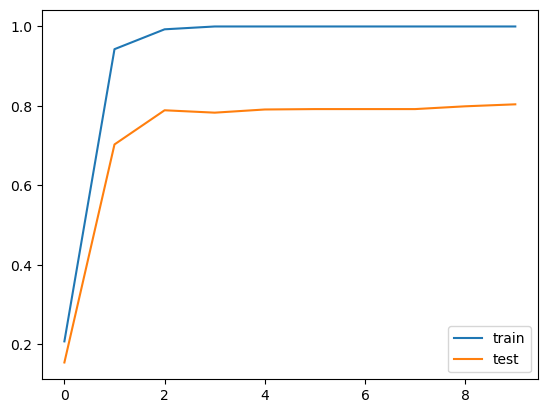

In [8]:
plt.plot(train_accs, label='train')
plt.plot(test_accs, label = 'test')
plt.legend()

# Graph Convolution Network for 2D representation

In [9]:
EPOCHS = 1000
LEARNING_RATE = 1e-2

model = GCN(in_channels=dataset.num_features, hidden_dim=2, out_channels=dataset.num_classes, adj = A, return_hidden=True)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)

In [10]:
losses = []
train_accs = []
test_accs = []

for epoch in range(EPOCHS):

    pred, z = model(X)
    loss = criterion(pred[train_index], y[train_index])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.detach())

    if epoch%10==0:
        with torch.no_grad():
            model.eval()

            preds, z = model(X)
            pred_train, y_train = preds[train_index], y[train_index]
            pred_test, y_test = preds[test_index], y[test_index]

            train_acc = accuracy(y_train, torch.argmax(pred_train, axis=1))
            test_acc = accuracy(y_test, torch.argmax(pred_test, axis=1))
            train_accs.append(train_acc)
            test_accs.append(test_acc)

            print(f"For epoch {epoch}, Train Accuracy : {train_acc}")
            print(f"For epoch {epoch}, Test Accuracy : {test_acc}")

            model.train()

For epoch 0, Train Accuracy : 0.1428571492433548
For epoch 0, Test Accuracy : 0.11999999731779099
For epoch 10, Train Accuracy : 0.19285714626312256
For epoch 10, Test Accuracy : 0.15199999511241913
For epoch 20, Train Accuracy : 0.3214285671710968
For epoch 20, Test Accuracy : 0.37599998712539673
For epoch 30, Train Accuracy : 0.4357142746448517
For epoch 30, Test Accuracy : 0.4269999861717224
For epoch 40, Train Accuracy : 0.44999998807907104
For epoch 40, Test Accuracy : 0.3930000066757202
For epoch 50, Train Accuracy : 0.6071428656578064
For epoch 50, Test Accuracy : 0.5460000038146973
For epoch 60, Train Accuracy : 0.7071428298950195
For epoch 60, Test Accuracy : 0.5799999833106995
For epoch 70, Train Accuracy : 0.7642857432365417
For epoch 70, Test Accuracy : 0.6039999723434448
For epoch 80, Train Accuracy : 0.8357142806053162
For epoch 80, Test Accuracy : 0.6439999938011169
For epoch 90, Train Accuracy : 0.8999999761581421
For epoch 90, Test Accuracy : 0.6549999713897705
For epo

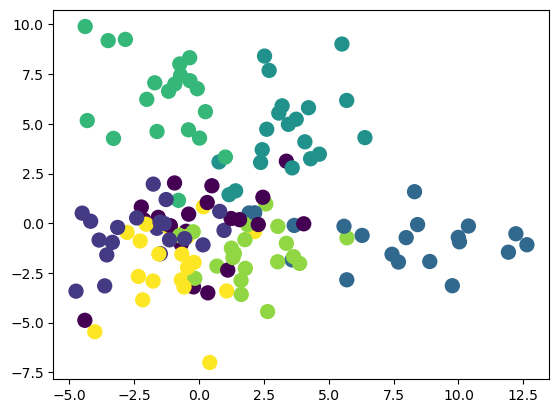

In [12]:
plt.scatter(z[train_index].T[0].detach(), z[train_index].T[1].detach(), c=y[train_index], s=100)